In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
from fastai.conv_learner import *
from fastai.dataset import *
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
warnings.filterwarnings('ignore')

In [2]:
PATH = './'
DATA_DIR = '/home/share/data_repos/hpi'
TRAIN = os.path.join(DATA_DIR, 'train')
TEST = os.path.join(DATA_DIR, 'test')
LABELS = os.path.join(DATA_DIR, 'train.csv')
SAMPLE = os.path.join(DATA_DIR, 'sample_submission.csv')

In [3]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [4]:
nw = 15   # number of workers for data loader
arch = resnet34 # specify target architecture

In [5]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [6]:
def open_rgby(path, id):  # a function that reads RGBY image
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)


class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()]
                                 for s in self.labels['Target']]
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_rgby(self.path, self.fnames[i])
        if self.sz == 512:
            return img
        else:
            return cv2.resize(img, (self.sz, self.sz), cv2.INTER_AREA)

    def get_y(self, i):
        if(self.path == TEST):
            return np.zeros(len(name_label_dict), dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict), dtype=np.float)[labels].sum(axis=0)

    @property
    def is_multi(self): return True

    @property
    def is_reg(self): return True
    # this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    # of the numerical stability of the loss function

    def get_c(self): return len(name_label_dict)  # number of classes


def get_data(sz, bs):
    # data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    # mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282],
              [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO,
                           aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

torch.Size([16, 4, 256, 256]) torch.Size([16, 28])


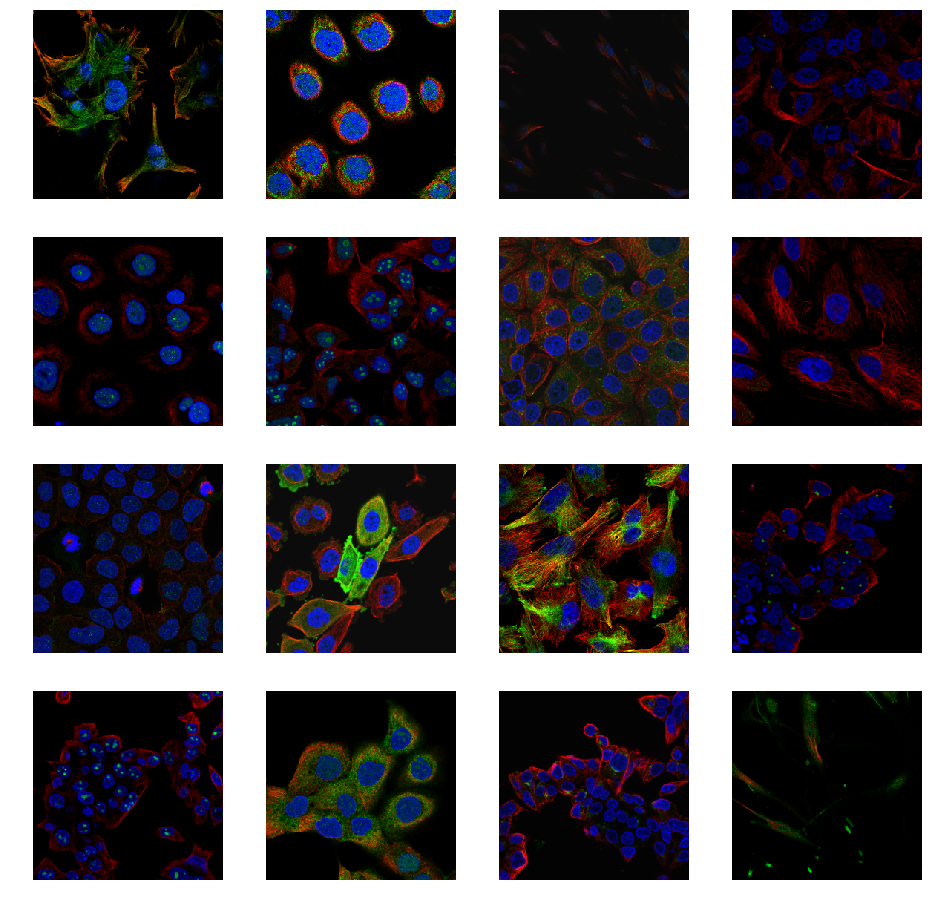

In [7]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4, 4)
    fig = plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx, :, :, :3]*255).astype(np.int))
    plt.show()


bs = 16
sz = 256
md = get_data(sz, bs)
x, y = next(iter(md.trn_dl))
print(x.shape, y.shape)
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss

        return loss.sum(dim=1).mean()


def acc(preds, targs, th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds == targs).float().mean()

In [10]:
class ConvnetBuilder_custom():
    
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0,
                 custom_head=None, pretrained=True):
        self.f, self.c, self.is_multi, self.is_reg, self.xtra_cut = f, c, is_multi, is_reg, xtra_cut
        if xtra_fc is None:
            xtra_fc = [512]
        if ps is None:
            ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps, self.xtra_fc = ps, xtra_fc

        if f in model_meta:
            cut, self.lr_cut = model_meta[f]
        else:
            cut, self.lr_cut = 0, 0
        cut -= xtra_cut
        layers = cut_model(f(pretrained), cut)

        w = layers[0].weight
        layers[0] = nn.Conv2d(4, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        layers[0].weight = nn.Parameter(torch.cat((w, w[:, :1, :, :]), dim=1))

        self.nf = model_features[f] if f in model_features else (
            num_features(layers)*2)
        if not custom_head:
            layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list):
            self.ps = [self.ps]*n_fc

        if custom_head:
            fc_layers = [custom_head]
        else:
            fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head:
            apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

        
    @property
    def name(self): 
        return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res = [nn.BatchNorm1d(num_features=ni)]
        if p:
            res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn:
            res.append(actn)
        return res

    def get_fc_layers(self):
        res = []
        ni = self.nf
        for i, nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni = nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg:
            final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        print(idxs)
        c = children(self.top_model)
        if len(c) == 3:
            c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c, idxs))
        return lgs+[self.fc_model]


class ConvLearner(Learner):
    
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [
                accuracy]
        if precompute:
            self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'):
            return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    
    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
                                       ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    
    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                     needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
                                ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn = cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn

    
    @property
    def model(self):
        
        return self.models.fc_model if self.precompute else self.models.model

    def half(self):
        if self.fp16:
            return
        self.fp16 = True
        if type(self.model) != FP16:
            self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16):
            self.models.fc_model = FP16(self.models.fc_model)

    def float(self):
        if not self.fp16:
            return
        self.fp16 = False
        if type(self.models.model) == FP16:
            self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16:
            self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0, n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl)
                 for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(
                self.models.nf, n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m = self.models.top_model
        if len(self.activations[0]) != len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1]) != len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2]) != len(self.data.test_ds)):
            if self.data.test_dl:
                predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                                                       (act, self.data.trn_y), (
                                                           val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                                                       test=test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [11]:
sz = 512   # image size
bs = 32    # batch size
md = get_data(sz, bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5)  # dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0  # gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

[6]


In [ ]:
learner.summary

In [ ]:
learner.lr_find()
learner.sched.plot()

## 设置学习率为最优值， 训练第一个卷积层和分类器（n_epochs=1）

In [12]:
lr = 1e-2
learner.fit(lr, 1)

[6]


epoch      trn_loss   val_loss   acc                          
    0      1.284037   1.23829    0.944831  



[1.238290193611744, 0.9448313563486784]

## Pretrain lr=2e-3 (n_epochs=8) 

### 这里将主干部分划分两个组，分类器作为一个组，每一组采用不同的学习率
### 越底层的特征提取层，学习率越小

In [13]:
learner.unfreeze()
lrs = np.array([lr/10, lr/3, lr])   # 2e-3, 7e-3, 2e-2
# 4代表循环周期数量， 2代表周期长度， use_clr表示如何划分一个周期，
# 10表示一个周期内学习率下降的倍数， 20代表一个周期中下降长度和升高长度的比例
learner.fit(lrs/4, 4, cycle_len=2, use_clr=(10, 20))

[6]
[6]


epoch      trn_loss   val_loss   acc                          
    0      0.906885   0.855326   0.960632  
    1      0.790144   0.698733   0.967526                      
    2      0.781729   0.774816   0.963631                      
    3      0.721899   0.636136   0.970215                      
    4      0.735488   0.70845    0.966078                      
    5      0.672505   0.660442   0.971008                      
    6      0.704541   0.646951   0.969618                      
    7      0.651774   0.582219   0.972536                      



[0.5822189444127077, 0.9725363572131713]

## 继续训练 (n_epochs=8) 

[6]


epoch      trn_loss   val_loss   acc                           
    0      0.699967   0.653423   0.968756  
    1      0.6619     0.646022   0.969526                      
    2      0.637492   0.58139    0.972215                      
    3      0.588978   0.55724    0.973203                      
    4      0.666472   0.652003   0.969503                      
    5      0.628276   0.591399   0.971491                      
    6      0.604964   0.566096   0.972801                      
    7      0.555567   0.538203   0.97418                       



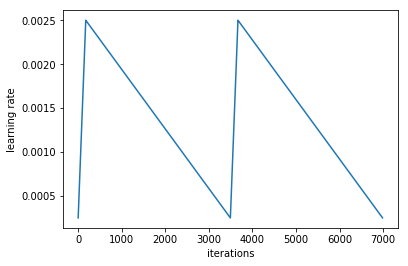

In [14]:
learner.fit(lrs/4, 2, cycle_len=4, use_clr=(10, 20))
learner.sched.plot_lr()

## 继续训练 (n_epochs=8) ， 一个周期长度越来越大

In [15]:
learner.fit(lrs/16, 1, cycle_len=8, use_clr=(5, 20))

[6]


epoch      trn_loss   val_loss   acc                           
    0      0.549817   0.555036   0.973605  
    1      0.539806   0.538659   0.974065                      
    2      0.553678   0.53984    0.973823                      
    3      0.528738   0.533028   0.974398                      
    4      0.529561   0.526432   0.974409                      
    5      0.505245   0.521967   0.974708                      
    6      0.482185   0.520496   0.974639                      
    7      0.485266   0.516044   0.975133                      



In [17]:
learner.save('ResNet34_512_1')
# learner.load('ResNet34_256_1')

## 性能评估(TTA)

In [18]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))


def F1_soft(preds, targs, th=0.5, d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    
    return score


def fit_val(x, y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5

    def error(p): return np.concatenate((F1_soft(x, y, p) - 1.0,
                                         wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    
    return p

preds, y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

计算最优阈值

In [19]:
th = fit_val(pred, y)
th[th < 0.1] = 0.1
print('Thresholds: ', th)
print('F1 macro: ', f1_score(y, pred > th, average='macro'))
print('F1 macro (th = 0.5): ', f1_score(y, pred > 0.5, average='macro'))
print('F1 micro: ', f1_score(y, pred > th, average='micro'))

Thresholds:  [0.56025 0.60101 0.55853 0.5504  0.58809 0.52247 0.56942 0.5769  0.75655 0.59106 0.67121 0.67687 0.54536
 0.5966  0.57357 0.1     0.60623 0.47062 0.53708 0.49868 0.46469 0.50243 0.49233 0.53891 0.58677 0.48384
 0.47075 0.5    ]
F1 macro:  0.6906840176558635
F1 macro (th = 0.5):  0.6445885450025249
F1 micro:  0.7775415539234636


In [21]:
print('Fractions of Positive samples: ', (pred > th).mean(axis=0))
print('Fractions (true) of Positive samples: ', (y > th).mean(axis=0))

Fractions of Positive samples:  [0.45914 0.037   0.10811 0.04923 0.05502 0.07722 0.02445 0.07529 0.00064 0.00097 0.00032 0.02831 0.02156
 0.00933 0.02896 0.04408 0.0045  0.00611 0.02413 0.04826 0.00772 0.12033 0.03218 0.09717 0.01158 0.31049
 0.01158 0.     ]
Fractions (true) of Positive samples:  [0.41634 0.04118 0.11486 0.05534 0.06113 0.08462 0.03282 0.08687 0.00097 0.00129 0.00032 0.03121 0.01931
 0.01287 0.0296  0.00032 0.01094 0.00483 0.02928 0.04923 0.00676 0.12484 0.02831 0.0991  0.0119  0.27027
 0.01062 0.00064]


In [ ]:
preds_t, y_t = learner.TTA(n_aug=16, is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1)  # max works better for F1 macro score

 94%|█████████▍| 15/16 [2:32:20<10:34, 634.02s/it]  

In [24]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames, pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

手动设置阈值

In [25]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
                 0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
                 0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t, th_t)

Fractions:  [0.45086 0.04914 0.10203 0.07341 0.08819 0.12306 0.08195 0.10588 0.00265 0.00197 0.00154 0.0629  0.05119
 0.02213 0.0429  0.00009 0.04384 0.02649 0.04538 0.07811 0.01154 0.15544 0.04606 0.1216  0.01521 0.26329
 0.03845 0.01675]


参考测试集的比例

In [26]:
lb_prob = [0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
           0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
           0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
           0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
           0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
           0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [27]:
def Count_soft(preds, th=0.5, d=50.0):
    preds = sigmoid_np(d*(preds - th))
    
    return preds.mean(axis=0)


def fit_test(x, y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5

    def error(p): 
        return np.concatenate((Count_soft(x, p) - y, wd*(p - 0.5)), axis=None)
    
    p, success = opt.leastsq(error, params)
    
    return p

根据测试集比例refine的阈值

In [28]:
th_t = fit_test(pred_t, lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.64682 0.43933 0.65275 0.39196 0.36669 0.48644 0.41694 0.53763 0.21705 0.20882 0.1578  0.51843 0.33786
 0.48385 0.47551 0.20189 0.44251 0.53809 0.52478 0.45047 0.4177  0.54762 0.47424 0.60071 0.54579 0.57036
 0.36813 0.1456 ]
Fractions:  [0.36293 0.04324 0.07571 0.05802 0.07281 0.07392 0.04222 0.07469 0.0088  0.00897 0.00786 0.0429  0.0417
 0.0141  0.04384 0.00761 0.02786 0.01419 0.02829 0.05802 0.00974 0.12494 0.0282  0.0746  0.00991 0.2203
 0.02811 0.00641]
Fractions (th = 0.5):  [0.51777 0.03794 0.12254 0.03709 0.04239 0.06862 0.02709 0.08588 0.00128 0.00077 0.00034 0.04615 0.02025
 0.01359 0.04127 0.00009 0.0188  0.01718 0.03469 0.0435  0.0053  0.16083 0.02521 0.10819 0.01179 0.3402
 0.01119 0.     ]


In [29]:
save_pred(pred_t, th_t, 'protein_classification_f.csv')
save_pred(pred_t, th, 'protein_classification_v.csv')
save_pred(pred_t, 0.5, 'protein_classification_05.csv')

结合validation数据集和测试集得出的阈值（修改特定类别的阈值）

In [30]:
class_list = [8, 9, 10, 15, 20, 24, 27]
for i in class_list:
    th_t[i] = th[i]
    
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [31]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

根据训练集的类别比例refine阈值

In [32]:
th_t = fit_test(pred_t, label_fraction)
th_t[th_t < 0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.59886 0.4749  0.51653 0.42692 0.41565 0.47189 0.46935 0.49153 0.45892 0.43539 0.42395 0.59038 0.47903
 0.43429 0.58558 0.36523 0.52157 0.64125 0.52388 0.48691 0.49664 0.5543  0.49726 0.53767 0.53629 0.54451
 0.514   0.34728]
Fractions:  [0.41531 0.04042 0.11502 0.04888 0.05914 0.07947 0.03213 0.08939 0.00162 0.00137 0.00085 0.03495 0.02179
 0.01692 0.03418 0.0006  0.01658 0.00667 0.02863 0.04683 0.00538 0.12066 0.02564 0.09426 0.01034 0.26414
 0.01025 0.00026]
